In [1]:
from pathlib import Path
import mre

from matplotlib import pyplot as plt
import numpy as np

from tomato.audio.pitchdistribution import PitchDistribution

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Logger

In [2]:
logger = mre.logging.get_jupyter_logger(__name__)
logger.info("Created logger")

INFO:__main__:Created logger


# Load annotations

In [3]:
annotations = mre.data.Annotation.from_mlflow()
annotations.head()


,mbid,verified,tonic,makam,observations,dunya_uid,mb_url
0,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,False,256.0,Acemasiran,,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,http://musicbrainz.org/recording/00f1c6d9-c8ee...
1,168f7c75-84fb-4316-99d7-acabadd3b2e6,False,115.2,Acemasiran,,168f7c75-84fb-4316-99d7-acabadd3b2e6,http://musicbrainz.org/recording/168f7c75-84fb...
2,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,False,232.5,Acemasiran,,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,http://musicbrainz.org/recording/24f549dd-3fa4...
3,407bb0b4-f19b-42ab-8c0a-9f1263126951,False,233.5,Acemasiran,,407bb0b4-f19b-42ab-8c0a-9f1263126951,http://musicbrainz.org/recording/407bb0b4-f19b...
4,443819eb-6092-420c-bd86-d946a0ad6555,False,219.6,Acemasiran,,443819eb-6092-420c-bd86-d946a0ad6555,http://musicbrainz.org/recording/443819eb-6092...


# Load pitch class distributions

In [4]:
pcd_paths = mre.data.PitchClassDistribution.from_mlflow()
pcd_paths[:5]

['/data/artifacts/1/c9e50e9a483940209b2be73f735ead63/artifacts/006536f8-bf54-4cc0-a510-5a52456d09f8.json',
 '/data/artifacts/1/c9e50e9a483940209b2be73f735ead63/artifacts/009309d2-c260-4808-8f1d-44a5ddc6bc5f.json',
 '/data/artifacts/1/c9e50e9a483940209b2be73f735ead63/artifacts/00a48b5f-a35a-436c-a7a0-4438130f4abf.json',
 '/data/artifacts/1/c9e50e9a483940209b2be73f735ead63/artifacts/00ab81ec-07f8-47ba-9610-47ad56393eb9.json',
 '/data/artifacts/1/c9e50e9a483940209b2be73f735ead63/artifacts/00be9a4b-b85f-4601-a6d5-9ce1f5b3f91c.json']

# Parse features and classes

In [5]:
# dummy read first feature to get the dimensions
dim2 = len(PitchDistribution.from_json(pcd_paths[0]).vals)

# read features and corresponding id
X = np.zeros((len(pcd_paths), dim2))
mbids = []
for ii, pf in enumerate(pcd_paths):
    X[ii, :] = PitchDistribution.from_json(pcd_paths[ii]).vals
    mbids.append(Path(pcd_paths[ii]).stem)

# get the class sorted for the id
y = annotations.data.set_index("mbid").loc[mbids].makam.values

# Try different shallow classifiers

In [6]:
n_repetitions = 10
n_cv_folds = 10
random_state = 1916  # death of Tanburi Cemil Bey for reproducibility
def bhat(vals_1, vals_2):
    return -np.log(np.sum(np.sqrt(vals_1 * vals_2)))

pipe = Pipeline([('classifier', RandomForestClassifier())])  # assign dummy classifier
search_space = [{'classifier': [SVC()],
                 'classifier__kernel': ['rbf', 'linear'],
                 'classifier__gamma': [0.001, 0.01, 0.1, 1],
                 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors': [1, 3, 5, 10],
                 'classifier__weights': ["uniform", "distance"],
                 'classifier__metric': ["euclidean", "manhattan", "chebyshev", bhat]},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 100, 200, 500, 1000],
                 'classifier__max_features': ['auto', 'log2'],
                 'classifier__criterion' :['gini', 'entropy']}]

best_scores = []
best_test_scores = []
best_estimators = []
estimators = []
for rr in range(random_state, random_state + 10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y, random_state=rr)

    clf = GridSearchCV(
        pipe,
        search_space,
        cv=n_cv_folds,
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=True)
    clf.fit(X_train, y_train)    
    
    # store relevant info
    estimators.append(clf)
    best_scores.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_.steps[0][1])
    
    # test
    y_pred = clf.best_estimator_.predict(X_test)
    best_test_scores.append(accuracy_score(y_test, y_pred))
    
    logger.info(
        "%d: Validation Accuracy = %.2f, Test Accuracy = %.2f, %s"
        % (rr - random_state + 1, best_scores[-1], best_test_scores[-1], type(best_estimators[-1])))


INFO:__main__:1: Validation Accuracy = 0.75, Test Accuracy = 0.69, <class 'sklearn.ensemble._forest.RandomForestClassifier'>
INFO:__main__:2: Validation Accuracy = 0.74, Test Accuracy = 0.70, <class 'sklearn.ensemble._forest.RandomForestClassifier'>
INFO:__main__:3: Validation Accuracy = 0.75, Test Accuracy = 0.74, <class 'sklearn.ensemble._forest.RandomForestClassifier'>
INFO:__main__:4: Validation Accuracy = 0.73, Test Accuracy = 0.74, <class 'sklearn.ensemble._forest.RandomForestClassifier'>
INFO:__main__:5: Validation Accuracy = 0.74, Test Accuracy = 0.68, <class 'sklearn.ensemble._forest.RandomForestClassifier'>
INFO:__main__:6: Validation Accuracy = 0.75, Test Accuracy = 0.72, <class 'sklearn.ensemble._forest.RandomForestClassifier'>
INFO:__main__:7: Validation Accuracy = 0.74, Test Accuracy = 0.75, <class 'sklearn.ensemble._forest.RandomForestClassifier'>
INFO:__main__:8: Validation Accuracy = 0.75, Test Accuracy = 0.68, <class 'sklearn.ensemble._forest.RandomForestClassifier'>


0.7430000000000001 0.007010574024154372
0.724 0.03773592452822642


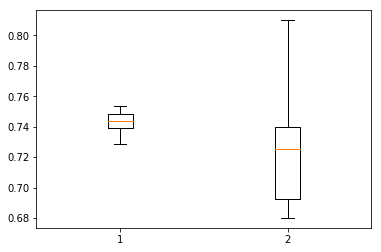

In [7]:
print(np.mean(best_scores), np.std(best_scores))
print(np.mean(best_test_scores), np.std(best_test_scores))

plt.boxplot((best_scores, best_test_scores))
plt.show()

In [8]:
display(confusion_matrix(y_true=y_test, y_pred=y_pred))
clf.classes_

array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

array(['Acemasiran', 'Acemkurdi', 'Bestenigar', 'Beyati', 'Hicaz',
       'Hicazkar', 'Huseyni', 'Huzzam', 'Karcigar', 'Kurdilihicazkar',
       'Mahur', 'Muhayyer', 'Neva', 'Nihavent', 'Rast', 'Saba', 'Segah',
       'Sultaniyegah', 'Suzinak', 'Ussak'], dtype=object)

In [9]:
print(estimators[0].cv_results_["params"][100], estimators[0].cv_results_["mean_test_score"][100])

{'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__criterion': 'entropy', 'classifier__max_features': 'auto', 'classifier__n_estimators': 200} 0.7477777777777778
